In [137]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
from graphviz import Source

from IPython.display import Image

%matplotlib inline

# Load Data

In [77]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [4]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

In [116]:
#y_train_label

# Decision Tree Class

In [111]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method for splitting node
        :param leaf_value_estimator: method for estimating leaf value
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth

    def fit(self, X, y=None):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want ot split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        n_samples, n_features = X.shape
    
        if self.depth >= self.max_depth or n_samples <= self.min_sample: 
            self.is_leaf = True 
            self.value = self.leaf_value_estimator(y)
            return self
        # Not leaf, need to split
        
        min_loss = 1e9
        self.split_id = None # Index of feature want to split 
        self.split_value = None # Value of feature 
        
        for feature in range(n_features):
            for sample in range(n_samples):
                left_labels = []
                right_labels = []
                for i in range(n_samples):
                    if X[i, feature] < X[sample, feature]:
                        left_labels.append(y[i])
                    else:
                        right_labels.append(y[i])
                loss = len(left_labels) * self.split_loss_function(left_labels)\
                    + len(right_labels) * self.split_loss_function(right_labels)
                if loss < min_loss: 
                    min_loss = loss 
                    self.split_id = feature
                    self.split_value = X[sample, feature] 
        left_side = []
        left_label = []
        right_side = []
        right_label = []
        for i in range(n_samples): 
            if X[i, self.split_id] < self.split_value:
                left_side.append(X[i, :])
                left_label.append(y[i])
            else: 
                right_side.append(X[i, :])
                right_label.append(y[i])
        
        if len(left_label) == 0 or len(right_label) == 0:
            self.is_leaf = True 
            self.value = self.leaf_value_estimator(y)
            return self            
                
        # left tree
        self.left = Decision_Tree(split_loss_function=self.split_loss_function,
                                 leaf_value_estimator=self.leaf_value_estimator,
                                 depth=self.depth + 1,
                                 min_sample=self.min_sample,
                                 max_depth=self.max_depth)
        self.left.fit(np.array(left_side), np.array(left_label))
        
        # right tree
        
        self.right = Decision_Tree(split_loss_function=self.split_loss_function,
                                 leaf_value_estimator=self.leaf_value_estimator,
                                 depth=self.depth + 1,
                                 min_sample=self.min_sample,
                                 max_depth=self.max_depth)
        self.right.fit(np.array(right_side), np.array(right_label))
        self.is_leaf = False
        return self

    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

In [102]:
X = []
y = []
for i in range(3): 
    X.append(x_train[i, :])
    y.append(y_train[i])

In [104]:
X = np.array(X)
y = np.array(y)

In [106]:
y.shape

(3, 1)

In [80]:
# a = [x_train[0, :], x_train[1, :]]
# a = np.array(a)
# a[0, :]

# Decision Tree Classifier

In [83]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return entropy: entropy value
    '''
    size = len(label_array)
    if size <= 1:
        return 0
    unique, counts = np.unique(label_array, return_counts = True)
    n_classes = len(unique)
    probs = counts / size # Get probability of each class
    entropy = 0
    for p in probs: 
        entropy -= p * np.log2(p) 
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    size = len(label_array)
    if size == 0:
        return
    # Need to get proportion of each class (i.e., number of label in class_i in the label_array)
    unique, counts = np.unique(label_array, return_counts = True)
    t = dict(zip(unique, counts))
    score = 0
    for class_i in t: 
        p = t[class_i] / size
        score += p * p
    gini = 1.0 - score
    return gini

In [41]:
# label_array = y_train_label
# label_array = label_array.reshape(len(label_array))
# print(compute_entropy(label_array))

In [42]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [89]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                most_common_label,
                                0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

In [113]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6)
clf6.fit(x_train, y_train_label)

Classification_Tree(loss_function=None, max_depth=None, min_sample=None)

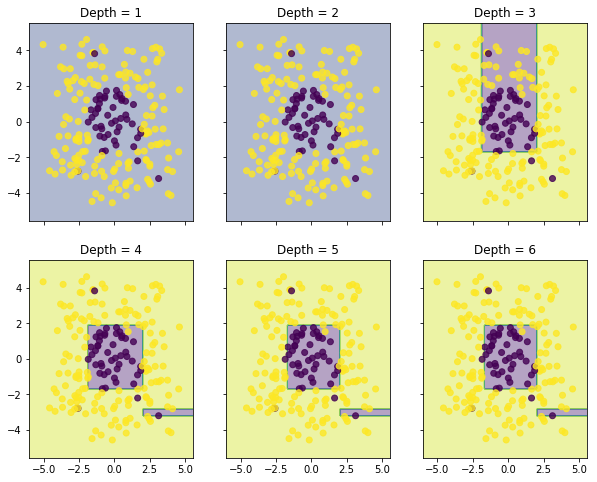

In [119]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    # y_train_label is an array of list, need to reshape y_train_label as an array of 1 list 
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [143]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=5)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

In [146]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png

/bin/sh: dot: command not found


In [145]:
Image(filename='tree_classifier.png')

# Decision Tree Regressor

In [147]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    med = np.median(y)
    ab_dev = [abs(i - med) for i in y] 
    mae = np.mean(ab_dev)
    return mae

In [148]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


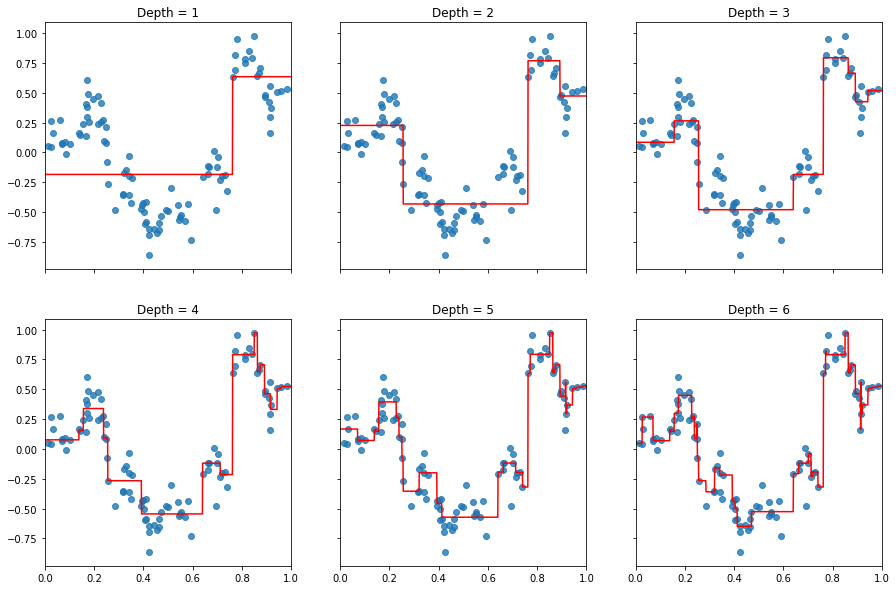

In [149]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1),data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1),data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=1, loss_function='mae', estimator='median')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=1, loss_function='mae', estimator='median')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=1, loss_function='mae', estimator='median')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=1, loss_function='mae', estimator='median')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=1, loss_function='mae', estimator='median')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=6,  min_sample=1, loss_function='mae', estimator='median')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

In [150]:
#Pseudo-residual function.
#Here you can assume that we are using L2 loss

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [302]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.1, min_sample=5, max_depth=3):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth
#         self.trees_list = [DecisionTreeRegressor(criterion='mse', 
#                                                  splitter='best', 
#                                                  max_depth=self.max_depth, 
#                                                  min_samples_split=self.min_sample)] * n_estimator

    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        '''
        funcs = [lambda x: np.zeros(x.shape[0])] # a list of function h 
        self.regressors = [] # a list of tree f
        predictions = np.zeros(train_data.shape[0]) # a list of predictions f_m(x) = f_(m - 1)(x) + v_m * h_m
        for i in range(self.n_estimator):
            predictions = predictions + self.learning_rate * funcs[-1](train_data)
            residuals = self.pseudo_residual_func(train_target.ravel(), predictions)
            model = DecisionTreeRegressor(criterion='mse', 
                                                 splitter='best', 
                                                 max_depth=self.max_depth, 
                                                 min_samples_split=self.min_sample)
            model.fit(train_data, residuals)
            self.regressors.append(model)
            funcs.append(lambda x: model.predict(x))
        
#         residual = train_target.copy()
#         for i in range(self.n_estimator): 
#             #print("Residual shape {}".format(residual.shape))
            
#             self.trees_list[i].fit(train_data, residual)            
#             this_tree_train_predict = self.learning_rate * self.trees_list[i].predict(train_data)
#             # Need to make it as an array with num_instances and each entry is a list 
#             this_tree_train_predict  = np.array([[i] for i in this_tree_train_predict])
            
#             #print('Residual * pred {}'.format(residual * this_tree_train_predict))
#             residual = self.pseudo_residual_func(residual, this_tree_train_predict)
#             #print('Residual after hinge {}'.format(residual))
#             #print("Residual shape {} this_tree_train_predict {}".format(residual.shape, this_tree_train_predict.shape))

#             # After fitting this tree, we want to fit train_data on residual, so the train_target = residual 
#             # We fit the next tree on the residual to get prediction on a new tree h_(i + 1)(X) 
#             # New residual = old residual - h_(i+1)(X)
            

        return self
    
    def predict(self, test_data):
        '''
        Predict value
        '''
        result = 0
        for tree in self.regressors: 
            pred = tree.predict(test_data)
            result += pred * self.learning_rate 
            #print("Result {} pred {}".format(result.shape, pred.shape))
        return result 
    

# 2-D GBM visualization - SVM data

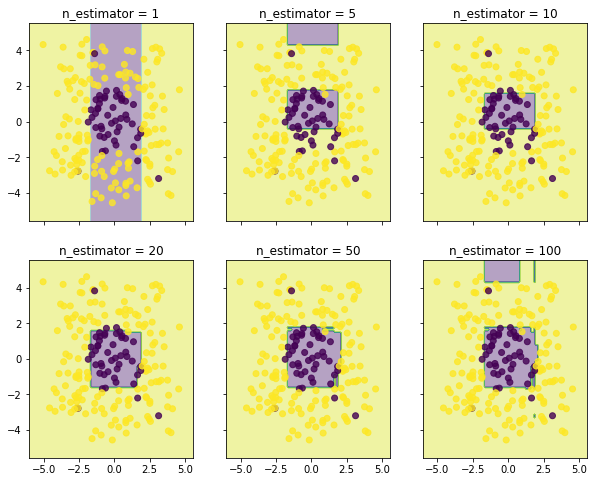

In [303]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbt.fit(x_train, y_train)
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

# 1-D GBM visualization - KRR data

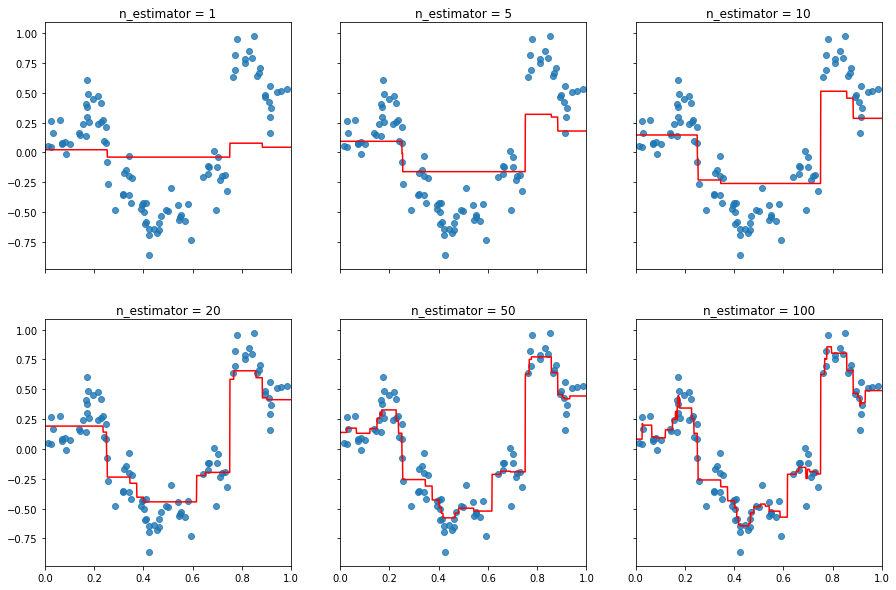

In [304]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

## Hinge Loss

In [324]:
#Pseudo-residual function.
#Here you can assume that we are using Hinge loss

def pseudo_residual_hinge(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    res = np.zeros((len(train_target), 1))
    for i in range(len(train_target)): 
        if train_target[i] * train_predict[i] < 1: 
            res[i] = train_target[i]
        else:
            res[i] = 0
    return res

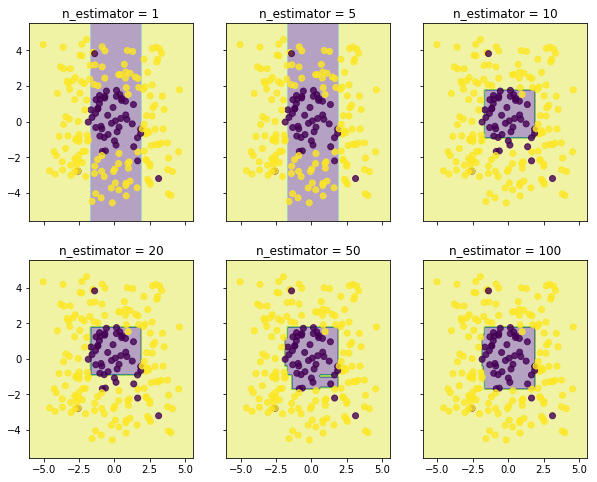

In [316]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_hinge, max_depth=2)  
    gbt.fit(x_train, y_train)
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

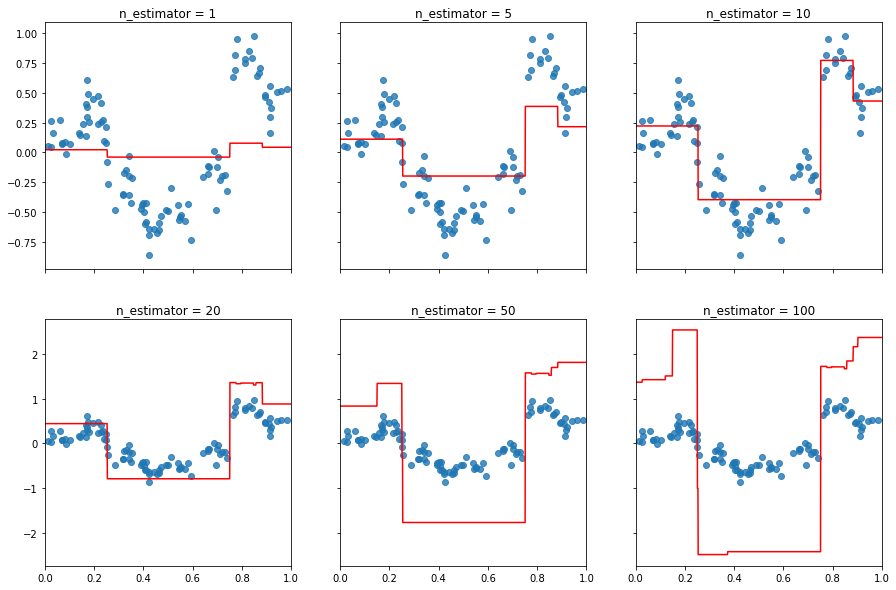

In [326]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_hinge, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

In [319]:
def pseudo_residual_logistic(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target / (1 + np.exp(train_target * train_predict))

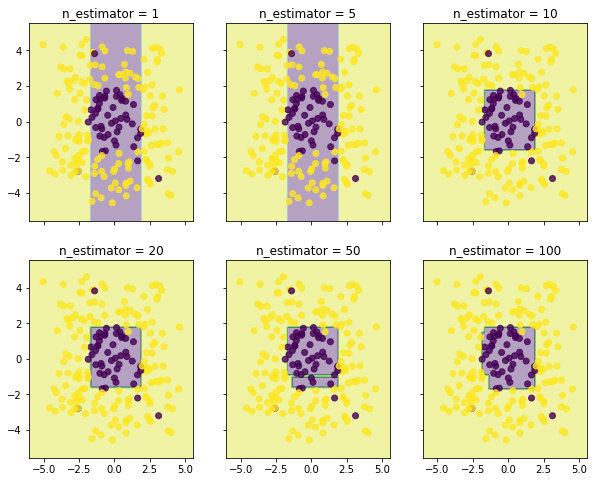

In [321]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbt = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)  
    gbt.fit(x_train, y_train)
    Z = np.sign(gbt.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label.reshape(-1), alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

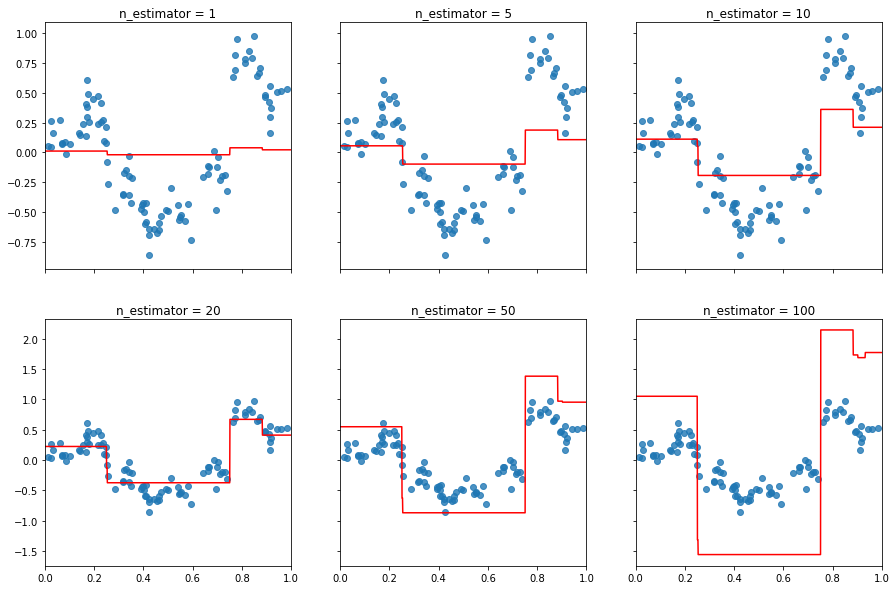

In [323]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_logistic, max_depth=2)  
    gbm_1d.fit(x_krr_train, y_krr_train)
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)